In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import torch
import torch.nn as nn
from PIL import Image
from torchsummary import summary
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.fc1 = nn.Linear(6272, 512)
        self.fc2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        conv2d_1 = F.relu(x)
        max_pooling2d_1 = F.max_pool2d(conv2d_1, kernel_size=2)
        
        x = self.conv2(max_pooling2d_1)
        conv2d_2 = F.relu(x)
        max_pooling2d_2 = F.max_pool2d(conv2d_2, kernel_size=2)
        
        x = self.conv3(max_pooling2d_2)
        conv2d_3 = F.relu(x)
        max_pooling2d_3 = F.max_pool2d(conv2d_3, kernel_size=2)
        
        x = self.conv4(max_pooling2d_3)
        conv2d_4 = F.relu(x)
        max_pooling2d_4 = F.max_pool2d(conv2d_4, kernel_size=2)
        
        batch_size, C, H, W = x.shape
        x = max_pooling2d_4.view(batch_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        features = {"conv2d_1": conv2d_1,
                    "max_pooling2d_1": max_pooling2d_1,
                    "conv2d_2": conv2d_2, 
                    "max_pooling2d_2": max_pooling2d_2, 
                    "conv2d_3": conv2d_3, 
                    "max_pooling2d_3": max_pooling2d_3,
                    "conv2d_4": conv2d_4,
                    "max_pooling2d_4": max_pooling2d_4}
        return features

In [3]:
model = torch.load("dogs_and_cats_small.pt")
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# model = Model().to(device)

In [4]:
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
            Conv2d-2           [-1, 64, 72, 72]          18,496
            Conv2d-3          [-1, 128, 34, 34]          73,856
            Conv2d-4          [-1, 128, 15, 15]         147,584
            Linear-5                  [-1, 512]       3,211,776
            Linear-6                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 9.23
Params size (MB): 13.17
Estimated Total Size (MB): 22.66
----------------------------------------------------------------


In [8]:
img_path = './data/cats_and_dogs_small/test/cats/cat.1700.jpg'

In [9]:
transform = transforms.Compose([transforms.Resize((150, 150)),
                                transforms.ToTensor()])

In [10]:
img = Image.open(img_path)

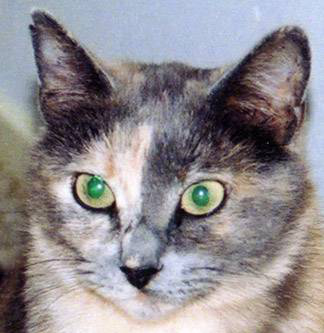

In [11]:
img

In [12]:
x = transform(img)

In [13]:
x = x.unsqueeze(0).to(device)

In [14]:
x.shape

torch.Size([1, 3, 150, 150])

In [15]:
features = model(x)

In [16]:
first_layer_activation = features['conv2d_1']

In [17]:
first_layer_activation.shape

torch.Size([1, 32, 148, 148])

In [18]:
first_layer_activation = first_layer_activation.squeeze(0).permute(1, 2, 0)

In [19]:
first_layer_activation.shape

torch.Size([148, 148, 32])

In [20]:
first_layer_activation = first_layer_activation.cpu().detach().numpy()

In [21]:
import matplotlib.pyplot as plt

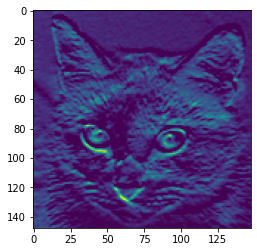

In [31]:
plt.imshow(first_layer_activation[:, :, 3])

In [26]:
images_per_row = 16

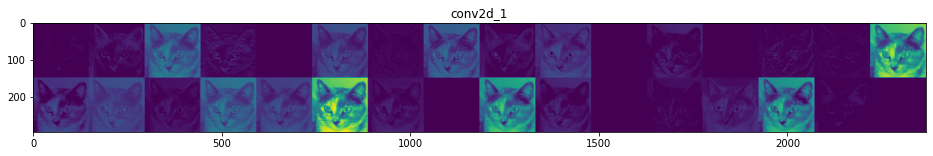

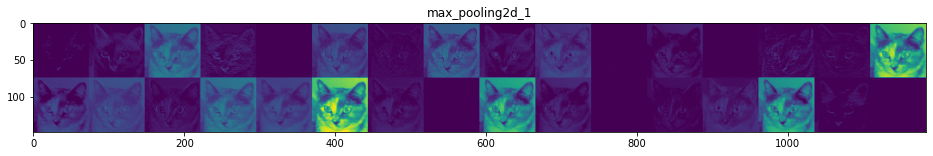

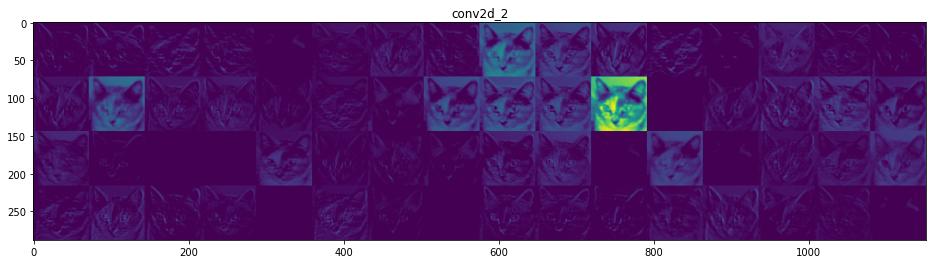

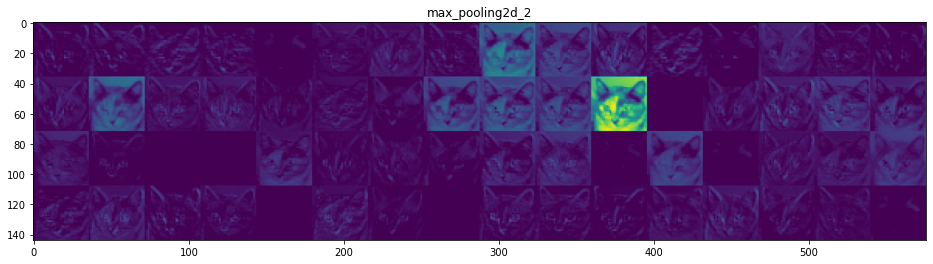

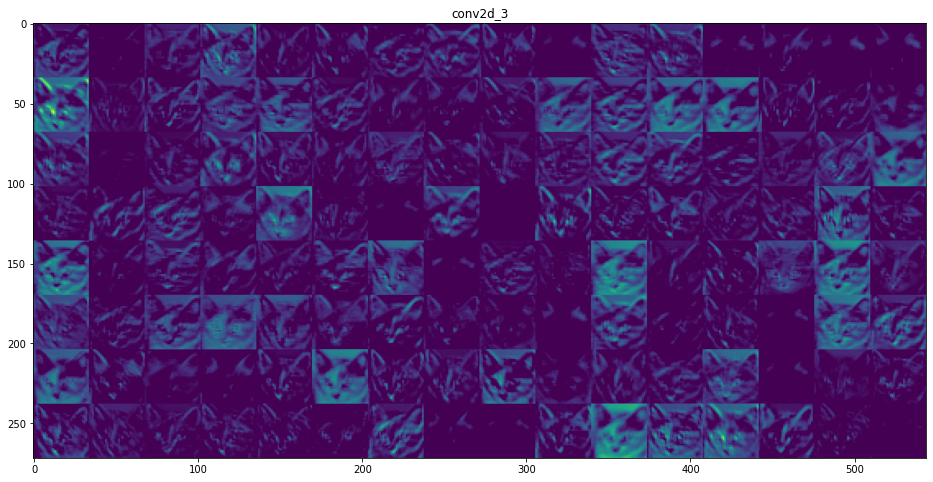

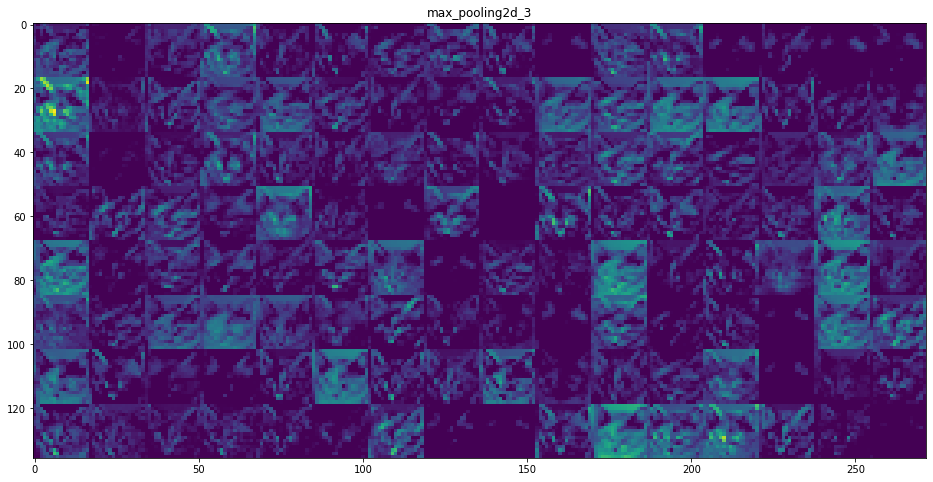

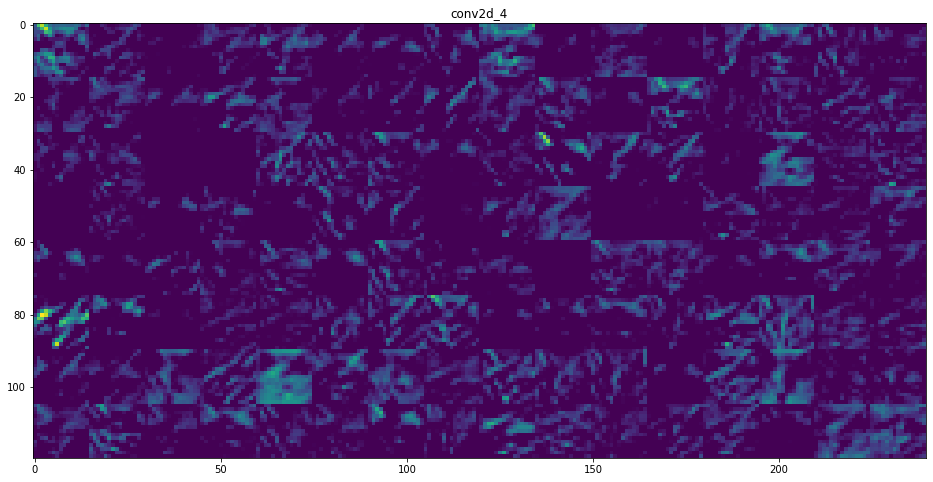

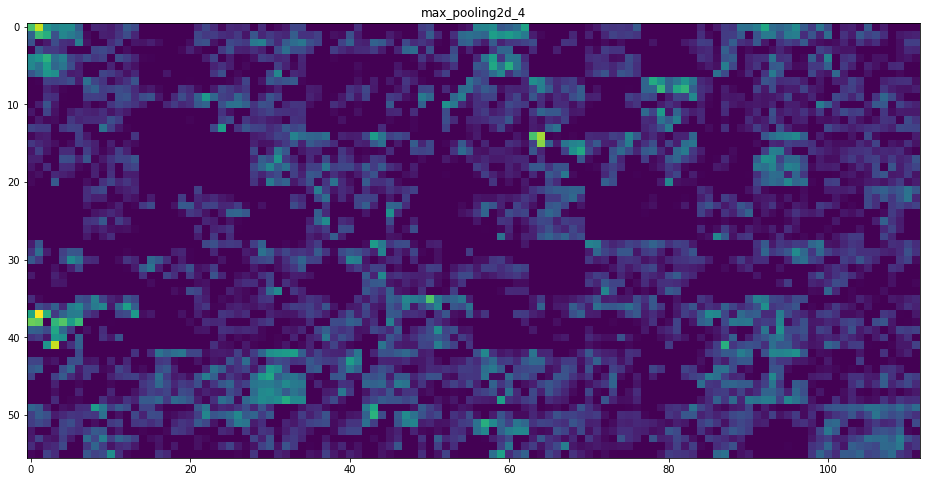

In [32]:
for layer_name, layer_feature in features.items():
    n_features = layer_feature.shape[1]
    size = layer_feature.shape[-1]
    n_row = n_features // images_per_row
    display_grid = np.zeros((size * n_row, images_per_row * size))
    for row in range(n_row):
        for col in range(images_per_row):
            the_layer_feature = layer_feature.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
            channel_image = the_layer_feature[:, :, row * images_per_row + col]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[row * size: (row+1) * size, col * size: (col+1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                    scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto')

In [29]:
x.device

device(type='cuda', index=0)

In [30]:
x.is_cuda

True

In [31]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'conv1',
 'conv2',
 'conv3',
 'conv4',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'fc1',
 'fc2',
 'float',
 'forward',
 'half',
 'load_state_dict',
